# Tensorflow

## 1.&nbsp; Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## 2.&nbsp; Parsing the raw data

In [6]:
# intermittent-renewables-production-france.csv
url = "https://drive.google.com/file/d/1OWsaiEalssU5lMxmhk9-f32zJXP7vY2r/view?usp=drive_link"
Solar_PATH = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]

In [7]:
Solar_cl = pd.read_csv(Solar_PATH, parse_dates=["Date and Hour"])

In [8]:
Solar_cl.head(5)

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-03-31 22:00:00+00:00,2020-04-01,1900-01-01 00:00:00,1900-01-01 01:00:00,Solar,0.0,92,Wednesday,April
1,2020-03-31 23:00:00+00:00,2020-04-01,1900-01-01 01:00:00,1900-01-01 02:00:00,Solar,0.0,92,Wednesday,April
2,2020-04-01 00:00:00+00:00,2020-04-01,1900-01-01 02:00:00,1900-01-01 03:00:00,Solar,0.0,92,Wednesday,April
3,2020-04-01 01:00:00+00:00,2020-04-01,1900-01-01 03:00:00,1900-01-01 04:00:00,Solar,0.0,92,Wednesday,April
4,2020-04-01 02:00:00+00:00,2020-04-01,1900-01-01 04:00:00,1900-01-01 05:00:00,Solar,0.0,92,Wednesday,April


In [9]:
def parse_data_from_file(filename):
    """Parse data from csv file

    Args:
        filename (str): complete path to file (path + filename)

    Returns:
        (np.ndarray, np.ndarray): arrays of timestamps and values of the time series
    """    
    # Load the production using np.loadtxt. Remember you want to skip the first 
    # row, since it's headers. Make sure to use the correct column of the csv file.
    #production = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=5, dtype=float)
    production_data = np.loadtxt(
        filename, 
        delimiter=",", 
        skiprows=1, 
        usecols=5,
        dtype=str
        #filling_values=np.nan  # Replace missing or empty values with NaN
        #invalid_raise=False      # Skip rows with invalid data
        )
    
    production = np.array(
        [float(val) if val != '' else np.nan for val in production_data]
        )

    # Generate indexes as dates/timestamps instead of reading from a file column.
    date = np.arange(len(production))
        
    return date, production

In [10]:
date_solar, production_solar = parse_data_from_file(Solar_PATH)

In [11]:
len(production_solar)

28462

In [12]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

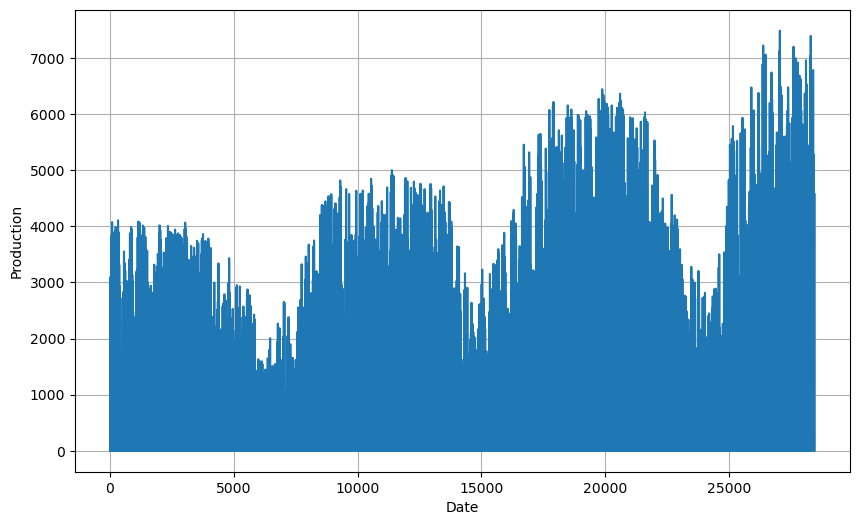

In [13]:
# Preview the data
plot_series(date_solar, production_solar, xlabel='Date', ylabel='Production')

## 3.&nbsp; Defining global variables

`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length of the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

In [14]:
SPLIT_TIME = 18976
WINDOW_SIZE = 20
BATCH_SIZE = 22
SHUFFLE_BUFFER_SIZE = 1000

## 4.&nbsp; Processing the data

### 4.1.&nbsp; Splitting data

In [15]:
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [16]:
# Split the dataset
time_train_solar, series_train_solar, time_valid_solar, series_valid_solar = train_val_split(date_solar, production_solar)

### 4.2.&nbsp; windowed data

In [17]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [18]:
def windowed_valid_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [19]:
# Apply the transformation to the training set
train_dataset_solar = windowed_dataset(series_train_solar, window_size=WINDOW_SIZE)
valid_dataset_solar = windowed_valid_dataset(series_train_solar, window_size=WINDOW_SIZE)

## 5.&nbsp; Defining the model architecture

### 5.1.&nbsp; create_uncompiled_model

Here is the model architecture we will be using. It is composed of Dense and LSTM layers with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. LSTM implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and we'll see that when you print the model summary below.

One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal`.

*Since, we will stack two LSTM layers in the model so the first one should have `return_sequences` set to `True`.*

In [ ]:
# GRADED FUNCTION: create_uncompiled_model
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """
    ### START CODE HERE ###
    
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE,1)), # Set the correct input shape for the model
        # 1D Convolution to capture local patterns with a larger kernel
		tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1,
                      activation="relu",
                      padding='causal'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        # LSTM layers to capture long term dependencies
        tf.keras.layers.LSTM(128, return_sequences=True),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(128),
        #tf.keras.layers.Dropout(0.2),
        # Dense layers for final prediction
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ]) 
    
    ### END CODE HERE ###
    return model

In [21]:
# Get your uncompiled model
uncompiled_model = create_uncompiled_model()

In [22]:
example_batch = train_dataset_solar.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (22, 1)


C:\Users\Eli\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [23]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,417 (1.05 MB)

 Trainable params: 276,417 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2.&nbsp; Adjusting the learning rate

In [69]:
def adjust_learning_rate(dataset):
    """Fit model using different learning rates

    Args:
        dataset (tf.data.Dataset): train dataset

    Returns:
        tf.keras.callbacks.History: callback history
    """

    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
    
    ### START CODE HERE ###
    
    # Select your optimizer
    #optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7), 
                  metrics=["mae"]) 
    
    ### END CODE HERE ###

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [70]:
# Run the training with dynamic LR
lr_history_wind = adjust_learning_rate(train_dataset_solar)

Epoch 1/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 943.5187 - mae: 943.5187 - learning_rate: 1.0000e-07
Epoch 2/100
  1/862 ━━━━━━━━━━━━━━━━━━━━ 2:02 142ms/step - loss: 694.8974 - mae: 694.8974

C:\Users\Eli\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 939.2277 - mae: 939.2277 - learning_rate: 1.1220e-07
Epoch 3/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 938.4844 - mae: 938.4844 - learning_rate: 1.2589e-07
Epoch 4/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 946.7924 - mae: 946.7924 - learning_rate: 1.4125e-07
Epoch 5/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 941.6155 - mae: 941.6154 - learning_rate: 1.5849e-07
Epoch 6/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 943.9518 - mae: 943.9518 - learning_rate: 1.7783e-07
Epoch 7/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 948.3159 - mae: 948.3159 - learning_rate: 1.9953e-07
Epoch 8/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 943.8920 - mae: 943.8920 - learning_rate: 2.2387e-07
Epoch 9/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 942.8955 - mae: 942.8956 - learning_rate: 2.5119e-07
Epoch 10/100
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 943.4552 - mae: 943.

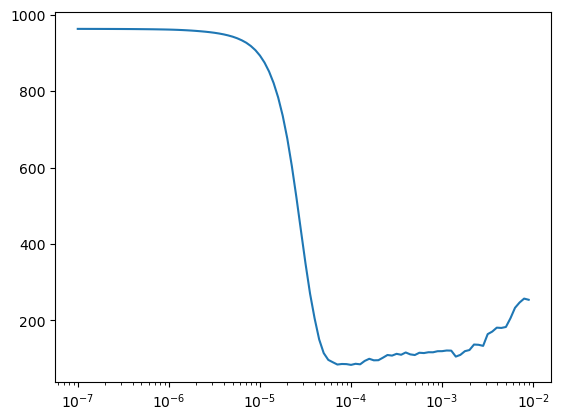

In [71]:
plt.semilogx(lr_history_wind.history["learning_rate"], lr_history_wind.history["loss"])

## 6.&nbsp; Compiling the model

In [ ]:
# GRADED FUNCTION: create_model
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """
    
    model = create_uncompiled_model()

    model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  metrics=["mae"])  
    

    return model

In [29]:
# Save an instance of the model
model = create_model()

In [30]:
# Train it
history_wind = model.fit(train_dataset_solar, epochs=200, validation_data=valid_dataset_solar)
#history = model.fit(
#    train_ds,
#    epochs=max_epochs,
#    validation_data=validate_ds)

Epoch 1/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 919.2713 - mae: 919.2713 - val_loss: 742.2431 - val_mae: 742.2432
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 561.6356 - mae: 561.6356 - val_loss: 319.4932 - val_mae: 319.4932
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 212.1975 - mae: 212.1975 - val_loss: 189.6812 - val_mae: 189.6812
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 117.2552 - mae: 117.2552 - val_loss: 129.0992 - val_mae: 129.0992
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 97.4880 - mae: 97.4880 - val_loss: 123.9464 - val_mae: 123.9464
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 88.0554 - mae: 88.0554 - val_loss: 128.7558 - val_mae: 128.7558
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 86.1207 - mae: 86.1207 - val_loss: 107.3342 - val_mae: 107.3342
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 80.2291 - mae: 80.2291 - val_loss: 150.0

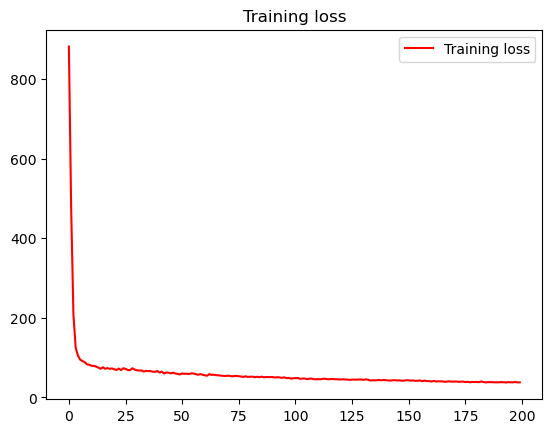

In [31]:
# Plot the training loss for each epoch

loss = history_wind.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## 7.&nbsp; Forecast model

In [32]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [33]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast_solar = model_forecast(model, production_solar[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


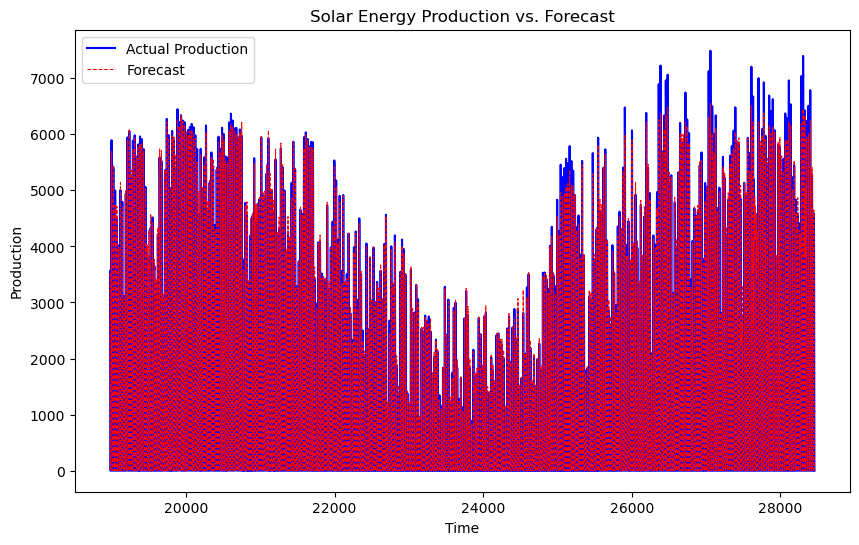

In [58]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot actual data in **blue**
plt.plot(time_valid_solar, series_valid_solar, label="Actual Production", color='blue', linewidth=1.5)

# Plot forecasted data in **red dashed line**
plt.plot(time_valid_solar, rnn_forecast_solar, label="Forecast", color='red', linestyle='dashed', linewidth=0.75)

# Labels and legend
plt.xlabel("Time")
plt.ylabel("Production")
plt.legend()
plt.title("Solar Energy Production vs. Forecast")

# Show the plot
plt.show()

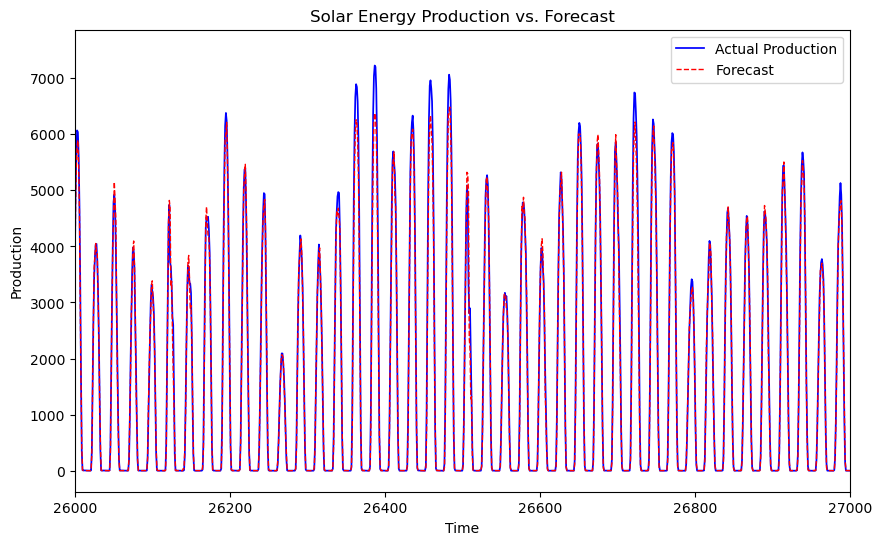

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot actual data in **blue**
plt.plot(time_valid_solar, series_valid_solar, label="Actual Production", color='blue', linewidth=1.25)

# Plot forecasted data in **red dashed line**
plt.plot(time_valid_solar, rnn_forecast_solar, label="Forecast", color='red', linestyle='dashed', linewidth=1)

# Labels and legend
plt.xlabel("Time")
# Set x-axis limits
plt.xlim(26000, 27000)  
plt.ylabel("Production")
plt.legend()
plt.title("Solar Energy Production vs. Forecast")

# Show the plot
plt.show()

## 8.&nbsp; Evaluating the forecast

In [36]:
def compute_metrics(true_series, forecast):
    """Computes MSE, MAE and MAPE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    mape = tf.keras.losses.MeanAbsolutePercentageError()(true_series, forecast).numpy()
    return mse, mae, mape

In [37]:
mse, mae, mape = compute_metrics(series_valid_solar, rnn_forecast_solar)

print(f"mse: {mse:.2f}, mae: {mae:.2f}, mape: {mape} for forecast")

mse: 25590.64, mae: 71.80, mape: 102889152.0 for forecast


## 9.&nbsp; Future data forecasting

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf

# For example, suppose you have a NumPy array of historical energy values
# Replace this with your actual training/observed data.
# Let's assume 'series_train_wind' is your historical energy array.
# For autoregressive predictions, we want to use the most recent 20 actual values as the seed.
window_size = 20
seed_data = rnn_forecast_solar[-window_size:]  # take the last 20 data points
seed_data = seed_data.reshape(1, window_size, 1)  # reshape to (batch_size, window_size, features)

# Define the prediction period: one year of hourly predictions.
start_time = pd.Timestamp("2023-06-30 21:00:00")
end_time = pd.Timestamp("2023-07-10 21:00:00")
time_index = pd.date_range(start=start_time, end=end_time, freq="h")
n_future_steps = len(time_index)

# Generate future predictions using the autoregressive approach.
future_predictions = []
input_sequence = seed_data.copy()

for step in range(n_future_steps):
    # Predict the next time step
    prediction = model.predict(input_sequence)
    predicted_value = prediction[0, 0]
    future_predictions.append(predicted_value)
    
    # Update input_sequence:
    # Shift the sequence one step to the left and append the new prediction at the end.
    input_sequence = np.roll(input_sequence, shift=-1, axis=1)
    input_sequence[0, -1, 0] = predicted_value

# Create a DataFrame with timestamps and predictions
predictions_df = pd.DataFrame({
    "Timestamp": time_index,
    "Predicted Energy": future_predictions
})

print(predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

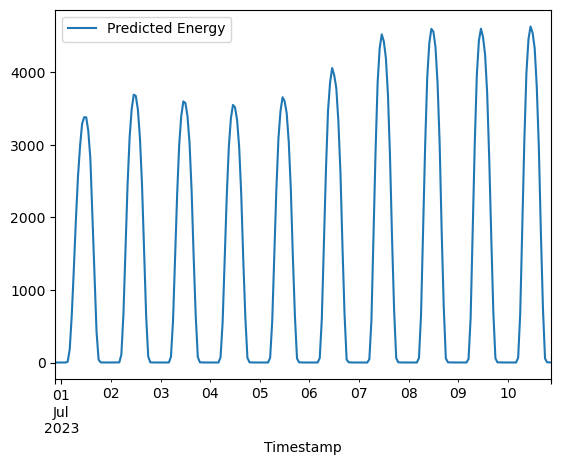

In [39]:
predictions_df.plot(x='Timestamp', y='Predicted Energy');

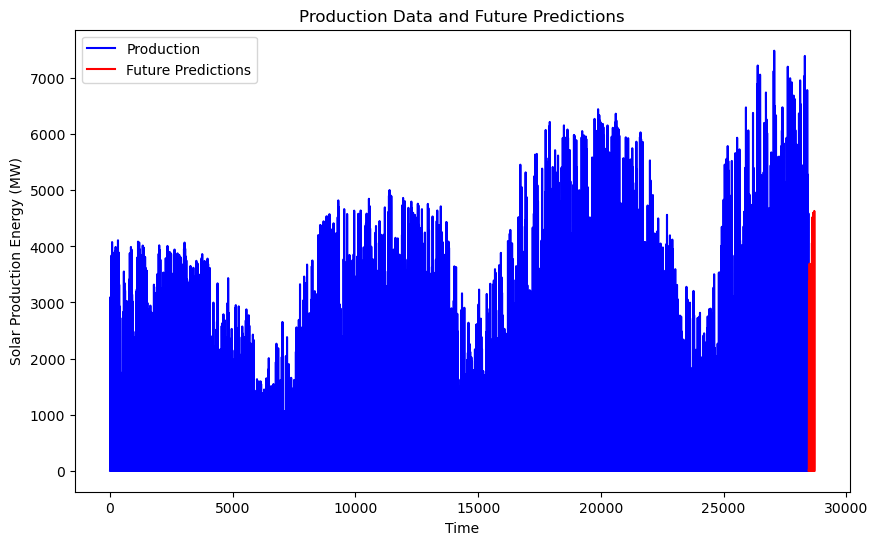

In [78]:
# Convert arrays to pandas Series
production_wind_series = pd.Series(production_solar)
future_predictions_series = pd.Series(future_predictions)

# Create date indices for each series
date_production = np.arange(len(production_wind_series))
# For future predictions, offset the dates to continue from production data
date_future = np.arange(len(production_wind_series), 
                        len(production_wind_series) + len(future_predictions_series))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot production data in blue
plt.plot(date_production, production_wind_series, label='Production', color='blue')

# Plot future predictions in red
plt.plot(date_future, future_predictions_series, label='Future Predictions', color='red')

# Add labels, legend, and title if needed
plt.xlabel('Time')
plt.ylabel('Solar Production Energy (MW)')
plt.legend()
plt.title('Production Data and Future Predictions')

# Show the plot
plt.show()

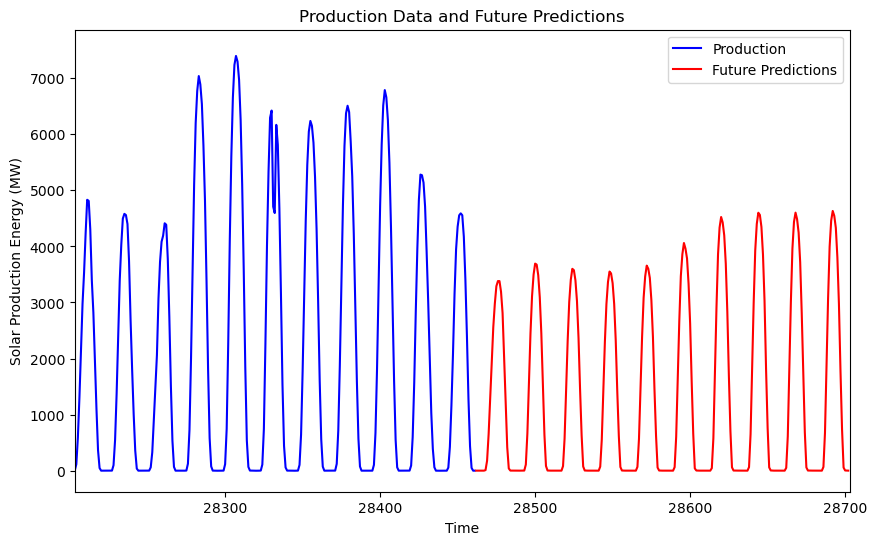

In [77]:
# Convert arrays to pandas Series
production_wind_series = pd.Series(production_solar)
future_predictions_series = pd.Series(future_predictions)

# Create date indices for each series
date_production = np.arange(len(production_wind_series))
# For future predictions, offset the dates to continue from production data
date_future = np.arange(len(production_wind_series), 
                        len(production_wind_series) + len(future_predictions_series))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot production data in blue
plt.plot(date_production, production_wind_series, label='Production', color='blue')

# Plot future predictions in red
plt.plot(date_future, future_predictions_series, label='Future Predictions', color='red')

# Add labels, legend, and title if needed
plt.xlabel('Time')
plt.xlim(len(production_wind_series) + len(future_predictions_series) - 500, 
         len(production_wind_series) + len(future_predictions_series))

plt.ylabel('Solar Production Energy (MW)')
plt.legend()
plt.title('Production Data and Future Predictions')

# Show the plot
plt.show()

## 10.&nbsp; Storing the RNN model with pickle

Once the RNN model has been trained, it can be stored and used for predictions without having to train it again. And this is what we will do with a library called ``pickle``.Install the library if needed, using pip or conda, and then simply use the pickle.dump function specifying the path to the folder where you want to store your model. 

In [72]:
# store the trained pipeline
import pickle
pickle.dump(model,
            open(file='models/rnn_forecast_solar.sav',
                 mode='wb'))